# Trying BarlowTwins on CIFAR-10

In [1]:
from os import makedirs

import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

from torchvision.models import resnet18

from models import BarlowTwins
#from optimizer import LARS
from trainer import SSL_Trainer
from utils import SSL_CIFAR10

# Define hyperparameters
data_root = '/home/space/datasets/'
#data_root = '/home/fcfschulz/Documents/workspace/data/Vision/'
save_root = './results/barlow_twins/'

dl_kwargs = {'batch_size': 512, 'shuffle': True, 'num_workers': 2}

# Define data
ssl_data = SSL_CIFAR10(data_root,'BYOL', dl_kwargs)

train_params = {'save_root': save_root, 'num_epochs': 15, 'optimizer': SGD,
                'scheduler': CosineAnnealingLR, 'warmup_epochs': 10, 'iter_scheduler':True,
                'evaluate_at': [100,200,400,600], 'verbose':True}

## In Original Paper for Imagenet when using LARS Optimizer
#optim_params = {'lr':0.2 * dl_kwargs['batch_size']/256, 'weight_decay': 1.5e-6,
#                'exclude_bias_and_norm': True}
optim_params = {'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 5e-4} # from here: https://github.com/IgorSusmelj/barlowtwins/blob/main/main.py

scheduler_params = {'T_max': (train_params['num_epochs']-train_params['warmup_epochs'])*len(ssl_data.train_dl)}
                    # 'eta_min': 1e-3} in orginal implementation

eval_params  = {'lr':1e-2, 'num_epochs': 25, 'milestones': [12,20]}

# Get device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Print Device Type
if torch.cuda.is_available():
    print(f"Program running on {torch.cuda.get_device_name(device)}")
else:
    print("Program running on CPU")
    
# Create folder if it does not exists
makedirs(save_root, exist_ok=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Program running on Tesla P100-PCIE-12GB


# BarlowTwins

In [2]:
# Define Model
resnet = resnet18(zero_init_residual=True)

barlow_twins = BarlowTwins(resnet, projector_hidden = (2048,2048,2048)).to(device)

# Define Trainer
cifar10_trainer = SSL_Trainer(barlow_twins, ssl_data, device)

# Train
cifar10_trainer.train(**train_params, optim_params=optim_params,
                      scheduler_params=scheduler_params, eval_params=eval_params)

# Evaluate
cifar10_trainer.evaluate(eval_params)
# print
print(f'Accuracy after Training: KNN:{cifar10_trainer.eval_acc["knn"][-1]},'\
      'Linear: {cifar10_trainer.eval_acc["lin"][-1]}')

Pretrained model available, use it?[y/n]: n


/home/fcfschulz/miniconda3/envs/pg_high/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0, Loss: 1360.4369513128222, Time epoch: 69.96186566352844
Epoch: 1, Loss: 1175.5099116059923, Time epoch: 69.98134708404541
Epoch: 2, Loss: 1058.355588303399, Time epoch: 70.75034832954407
Epoch: 3, Loss: 984.5984176163821, Time epoch: 70.05913186073303
Epoch: 4, Loss: 944.8627388551063, Time epoch: 70.17731785774231
Epoch: 5, Loss: 939.6945190429688, Time epoch: 69.74024057388306
Epoch: 6, Loss: 920.9936529729785, Time epoch: 70.21065425872803
Epoch: 7, Loss: 894.9764863633618, Time epoch: 70.10816478729248
Epoch: 8, Loss: 859.2807227065882, Time epoch: 69.81959581375122
Epoch: 9, Loss: 817.2354818127819, Time epoch: 69.87366366386414
Epoch: 10, Loss: 775.6140583470925, Time epoch: 70.23604488372803
Epoch: 11, Loss: 725.6529597646182, Time epoch: 70.31710839271545
Epoch: 12, Loss: 695.8889405555332, Time epoch: 70.32811832427979
Epoch: 13, Loss: 661.7340912179849, Time epoch: 69.67366099357605
Epoch: 14, Loss: 647.165449948655, Time epoch: 70.42487621307373
Accuracy after full

TypeError: evaluate() missing 1 required positional argument: 'lr'

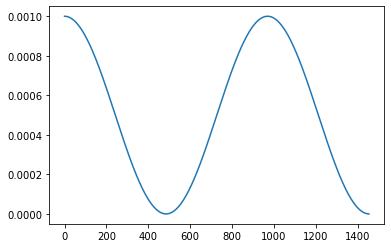

In [3]:
import matplotlib.pyplot as plt

plt.plot(cifar10_trainer._hist_lr);